In [16]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor, FullyConnectedBackend, TransformerBackend
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [8]:
str(config.data_config.frequency)

'1Day'

In [9]:
retriever = StooqRetriever(download_from_gdrive=False)
initial_state = config.model_config.model.state_dict()

In [10]:
def evaluate_signal_predictor(end_date: datetime, train_set_last_date: datetime, val_set_last_date: datetime, model=None):
    print(f'Running experiment for {config.data_config.start} to {end_date} with train set last date {train_set_last_date} and val set last date {val_set_last_date}')
    
    retrieval_result = retriever.bars(start=config.data_config.start, end=end_date)

    data_preparer = DataPreparer(
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler,
        in_seq_len=config.data_config.in_seq_len,
        frequency=str(config.data_config.frequency),
        validator=Validator(),
        backend='threading'
    )

    (X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
        data_preparer.get_experiment_data(
            data=retrieval_result,
            start_date=None,
            end_date=None,
            features=config.data_config.features,
            statistics=config.data_config.statistics,
            target=config.data_config.target,
            train_set_last_date=train_set_last_date,
            val_set_last_date=val_set_last_date,
        )
    next_return_train, spread_train, volatility_train, \
        next_return_val, spread_val, volatility_val, \
        next_return_test, spread_test, volatility_test = \
            statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
            statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
            statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']
        
    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape,\
         y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            early_stopping_patience=config.train_config.early_stopping_patience,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    trajectory_length = 12
    horizon = 30
    test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
            trajectory_length=trajectory_length, horizon=horizon).as_dataloader(
        batch_size=1, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
    )

    backend = FullyConnectedBackend(
        n_assets=len(config.data_config.symbol_or_symbols),
        hidden_dim=128,
        num_layers=2, 
        dropout=0.1,
        use_layer_norm=False,
    )

    actor = RlActor(
        copy.deepcopy(model), 
        backend,
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
        exploration_eps=0.0
    ).to(device)

    signal_predictor_actor = SignalPredictorActor(
        copy.deepcopy(model), 
        trade_asset_count=1,
        train_signal_predictor=False
    ).to(device)

    rl_agent = RlAgent(
        actor, 
        env
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        test_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=ReinforceLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor, test_trajectory_loader)
    return realized_returns_signal_predictor, model


In [11]:
# start_end_last_train_dates = [
#     {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
# ]
start_end_last_train_dates = [
    {'end': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2009, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 1, 1, tzinfo=timezone.utc)},
]

In [12]:
realized_returns = []
for i in range(len(start_end_last_train_dates)):
    best_model = None
    best_mean_return = 0
    # for j in range(1): 
    #     cur_rezlized_returns, model = evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['start'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         start_end_last_train_dates[i]['last_train_date'])
    #     if np.mean(cur_rezlized_returns) > best_mean_return:
    #         best_mean_return = np.mean(cur_rezlized_returns)
    #         best_model = model

    realized_returns.extend(
        evaluate_signal_predictor(
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date'], 
            start_end_last_train_dates[i]['last_val_date'], 
            best_model)[0])

Running experiment for 1970-01-02 00:00:00-05:00 to 2010-01-01 00:00:00+00:00 with train set last date 2008-01-01 00:00:00+00:00 and val set last date 2009-01-01 00:00:00+00:00


2025-11-11 12:41:55,824 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:41:56,162 - INFO - Found 8959 train slices, 253 val slices, 252 test slices
2025-11-11 12:41:56,163 - INFO - Trained per-asset targets
2025-11-11 12:41:56,292 - INFO - Input data validated!
2025-11-11 12:41:58,672 - INFO - Filled data validated!
2025-11-11 12:42:00,527 - INFO - Normalised features validated!
2025-11-11 12:42:00,742 - INFO - X validated!
2025-11-11 12:42:00,832 - INFO - Target mean: 0.5497207641601562
2025-11-11 12:42:00,833 - INFO - Target validated!
2025-11-11 12:42:00,859 - INFO - Statistics 'next_return' validated!
2025-11-11 12:42:00,901 - INFO - Statistics 'volatility' validated!
2025-11-11 12:42:00,925 - INFO - Statistics 'spread' validated!
2025-11-11 12:42:01,175 - INFO - Input data validated!
2025-11-11 12:42:01,382 - INFO - Filled data validated!
2025-11-11 12:42:01,930 - INFO - Normalised features validated!
2025-11-11 12:42:01,938 - INFO - X validated!
2025-11-11 12:4

(13789, 30, 30, 16) (13789, 30) (13789, 30) (13789, 30) (13789, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-11 12:42:06,401 - INFO - Train Loss: 0.1674         
2025-11-11 12:42:06,401 - INFO - Train Rmse: 0.4088
2025-11-11 12:42:06,401 - INFO - Val   Loss: 0.2787
2025-11-11 12:42:06,402 - INFO - Val   Rmse: 0.5278
2025-11-11 12:42:06,402 - INFO - 
2025-11-11 12:42:06,403 - INFO - Epoch 2/20
2025-11-11 12:42:08,774 - INFO - Train Loss: 0.1675         
2025-11-11 12:42:08,774 - INFO - Train Rmse: 0.4090
2025-11-11 12:42:08,775 - INFO - Val   Loss: 0.2826
2025-11-11 12:42:08,775 - INFO - Val   Rmse: 0.5315
2025-11-11 12:42:08,775 - INFO - 
2025-11-11 12:42:08,775 - INFO - Epoch 3/20
2025-11-11 12:42:11,139 - INFO - Train Loss: 0.1675         
2025-11-11 12:42:11,140 - INFO - Train Rmse: 0.4090
2025-11-11 12:42:11,140 - INFO - Val   Loss: 0.2810
2025-11-11 12:42:11,140 - INFO - Val   Rmse: 0.5300
2025-11-11 12:42:11,140 - INFO - 
2025-11-11 12:42:11,140 - INFO - Epoch 4/20
2025-11-11 12:42:13,447 - INFO - Train Loss: 0.1674         
2025-11-11 12:42:13,448 - INFO - Train Rmse: 0.4089
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2011-01-01 00:00:00+00:00 with train set last date 2009-01-01 00:00:00+00:00 and val set last date 2010-01-01 00:00:00+00:00


2025-11-11 12:42:47,286 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:42:47,520 - INFO - Found 9212 train slices, 252 val slices, 252 test slices
2025-11-11 12:42:47,520 - INFO - Trained per-asset targets
2025-11-11 12:42:47,647 - INFO - Input data validated!
2025-11-11 12:42:50,254 - INFO - Filled data validated!
2025-11-11 12:42:52,133 - INFO - Normalised features validated!
2025-11-11 12:42:52,345 - INFO - X validated!
2025-11-11 12:42:52,438 - INFO - Target mean: 0.545936644077301
2025-11-11 12:42:52,439 - INFO - Target validated!
2025-11-11 12:42:52,465 - INFO - Statistics 'next_return' validated!
2025-11-11 12:42:52,508 - INFO - Statistics 'volatility' validated!
2025-11-11 12:42:52,532 - INFO - Statistics 'spread' validated!
2025-11-11 12:42:52,779 - INFO - Input data validated!
2025-11-11 12:42:52,983 - INFO - Filled data validated!
2025-11-11 12:42:53,517 - INFO - Normalised features validated!
2025-11-11 12:42:53,526 - INFO - X validated!
2025-11-11 12:42

(14155, 30, 30, 16) (14155, 30) (14155, 30) (14155, 30) (14155, 30) (273, 30, 30, 16) (273, 30) (273, 30) (273, 30) (273, 30)
Training model...


2025-11-11 12:42:57,999 - INFO - Train Loss: 0.1698         
2025-11-11 12:42:57,999 - INFO - Train Rmse: 0.4118
2025-11-11 12:42:58,000 - INFO - Val   Loss: 0.2378
2025-11-11 12:42:58,000 - INFO - Val   Rmse: 0.4876
2025-11-11 12:42:58,000 - INFO - 
2025-11-11 12:42:58,001 - INFO - Epoch 2/20
2025-11-11 12:43:00,505 - INFO - Train Loss: 0.1699         
2025-11-11 12:43:00,505 - INFO - Train Rmse: 0.4119
2025-11-11 12:43:00,505 - INFO - Val   Loss: 0.2371
2025-11-11 12:43:00,505 - INFO - Val   Rmse: 0.4869
2025-11-11 12:43:00,506 - INFO - 
2025-11-11 12:43:00,507 - INFO - Epoch 3/20
2025-11-11 12:43:03,004 - INFO - Train Loss: 0.1700         
2025-11-11 12:43:03,005 - INFO - Train Rmse: 0.4120
2025-11-11 12:43:03,005 - INFO - Val   Loss: 0.2379
2025-11-11 12:43:03,005 - INFO - Val   Rmse: 0.4876
2025-11-11 12:43:03,005 - INFO - 
2025-11-11 12:43:03,006 - INFO - Epoch 4/20
2025-11-11 12:43:05,458 - INFO - Train Loss: 0.1699         
2025-11-11 12:43:05,458 - INFO - Train Rmse: 0.4118
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2012-01-01 00:00:00+00:00 with train set last date 2010-01-01 00:00:00+00:00 and val set last date 2011-01-01 00:00:00+00:00


2025-11-11 12:43:40,921 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:43:41,168 - INFO - Found 9464 train slices, 252 val slices, 252 test slices
2025-11-11 12:43:41,169 - INFO - Trained per-asset targets
2025-11-11 12:43:41,299 - INFO - Input data validated!
2025-11-11 12:43:43,794 - INFO - Filled data validated!
2025-11-11 12:43:45,847 - INFO - Normalised features validated!
2025-11-11 12:43:46,071 - INFO - X validated!
2025-11-11 12:43:46,166 - INFO - Target mean: 0.5481221079826355
2025-11-11 12:43:46,167 - INFO - Target validated!
2025-11-11 12:43:46,193 - INFO - Statistics 'next_return' validated!
2025-11-11 12:43:46,237 - INFO - Statistics 'volatility' validated!
2025-11-11 12:43:46,261 - INFO - Statistics 'spread' validated!
2025-11-11 12:43:46,518 - INFO - Input data validated!
2025-11-11 12:43:46,724 - INFO - Filled data validated!
2025-11-11 12:43:47,262 - INFO - Normalised features validated!
2025-11-11 12:43:47,270 - INFO - X validated!
2025-11-11 12:4

(14520, 30, 30, 16) (14520, 30) (14520, 30) (14520, 30) (14520, 30) (273, 30, 30, 16) (273, 30) (273, 30) (273, 30) (273, 30)
Training model...


2025-11-11 12:43:51,810 - INFO - Train Loss: 0.1715         
2025-11-11 12:43:51,810 - INFO - Train Rmse: 0.4138
2025-11-11 12:43:51,810 - INFO - Val   Loss: 0.2509
2025-11-11 12:43:51,811 - INFO - Val   Rmse: 0.5008
2025-11-11 12:43:51,811 - INFO - 
2025-11-11 12:43:51,812 - INFO - Epoch 2/20
2025-11-11 12:43:54,334 - INFO - Train Loss: 0.1716         
2025-11-11 12:43:54,334 - INFO - Train Rmse: 0.4139
2025-11-11 12:43:54,335 - INFO - Val   Loss: 0.2509
2025-11-11 12:43:54,335 - INFO - Val   Rmse: 0.5008
2025-11-11 12:43:54,335 - INFO - 
2025-11-11 12:43:54,336 - INFO - Epoch 3/20
2025-11-11 12:43:56,806 - INFO - Train Loss: 0.1716         
2025-11-11 12:43:56,807 - INFO - Train Rmse: 0.4140
2025-11-11 12:43:56,807 - INFO - Val   Loss: 0.2534
2025-11-11 12:43:56,807 - INFO - Val   Rmse: 0.5033
2025-11-11 12:43:56,807 - INFO - 
2025-11-11 12:43:56,807 - INFO - Epoch 4/20
2025-11-11 12:43:59,291 - INFO - Train Loss: 0.1715         
2025-11-11 12:43:59,291 - INFO - Train Rmse: 0.4139
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2013-01-01 00:00:00+00:00 with train set last date 2011-01-01 00:00:00+00:00 and val set last date 2012-01-01 00:00:00+00:00


2025-11-11 12:44:42,360 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:44:42,615 - INFO - Found 9716 train slices, 252 val slices, 250 test slices
2025-11-11 12:44:42,616 - INFO - Trained per-asset targets
2025-11-11 12:44:42,749 - INFO - Input data validated!
2025-11-11 12:44:45,298 - INFO - Filled data validated!
2025-11-11 12:44:47,252 - INFO - Normalised features validated!
2025-11-11 12:44:47,609 - INFO - X validated!
2025-11-11 12:44:47,707 - INFO - Target mean: 0.5491411685943604
2025-11-11 12:44:47,707 - INFO - Target validated!
2025-11-11 12:44:47,734 - INFO - Statistics 'next_return' validated!
2025-11-11 12:44:47,777 - INFO - Statistics 'volatility' validated!
2025-11-11 12:44:47,801 - INFO - Statistics 'spread' validated!
2025-11-11 12:44:48,064 - INFO - Input data validated!
2025-11-11 12:44:48,272 - INFO - Filled data validated!
2025-11-11 12:44:48,813 - INFO - Normalised features validated!
2025-11-11 12:44:48,822 - INFO - X validated!
2025-11-11 12:4

(14885, 30, 30, 16) (14885, 30) (14885, 30) (14885, 30) (14885, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-11 12:44:53,428 - INFO - Train Loss: 0.1732         
2025-11-11 12:44:53,428 - INFO - Train Rmse: 0.4159
2025-11-11 12:44:53,428 - INFO - Val   Loss: 0.2570
2025-11-11 12:44:53,429 - INFO - Val   Rmse: 0.5069
2025-11-11 12:44:53,429 - INFO - 
2025-11-11 12:44:53,430 - INFO - Epoch 2/20
2025-11-11 12:44:56,024 - INFO - Train Loss: 0.1733         
2025-11-11 12:44:56,024 - INFO - Train Rmse: 0.4160
2025-11-11 12:44:56,024 - INFO - Val   Loss: 0.2573
2025-11-11 12:44:56,025 - INFO - Val   Rmse: 0.5072
2025-11-11 12:44:56,025 - INFO - 
2025-11-11 12:44:56,025 - INFO - Epoch 3/20
2025-11-11 12:44:58,598 - INFO - Train Loss: 0.1734         
2025-11-11 12:44:58,598 - INFO - Train Rmse: 0.4161
2025-11-11 12:44:58,598 - INFO - Val   Loss: 0.2586
2025-11-11 12:44:58,599 - INFO - Val   Rmse: 0.5084
2025-11-11 12:44:58,599 - INFO - 
2025-11-11 12:44:58,599 - INFO - Epoch 4/20
2025-11-11 12:45:01,173 - INFO - Train Loss: 0.1733         
2025-11-11 12:45:01,173 - INFO - Train Rmse: 0.4160
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2014-01-01 00:00:00+00:00 with train set last date 2012-01-01 00:00:00+00:00 and val set last date 2013-01-01 00:00:00+00:00


2025-11-11 12:45:46,479 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:45:46,738 - INFO - Found 9968 train slices, 250 val slices, 252 test slices
2025-11-11 12:45:46,738 - INFO - Trained per-asset targets
2025-11-11 12:45:46,874 - INFO - Input data validated!
2025-11-11 12:45:49,476 - INFO - Filled data validated!
2025-11-11 12:45:51,602 - INFO - Normalised features validated!
2025-11-11 12:45:51,850 - INFO - X validated!
2025-11-11 12:45:51,951 - INFO - Target mean: 0.5494360327720642
2025-11-11 12:45:51,951 - INFO - Target validated!
2025-11-11 12:45:51,978 - INFO - Statistics 'next_return' validated!
2025-11-11 12:45:52,023 - INFO - Statistics 'volatility' validated!
2025-11-11 12:45:52,048 - INFO - Statistics 'spread' validated!
2025-11-11 12:45:52,329 - INFO - Input data validated!
2025-11-11 12:45:52,534 - INFO - Filled data validated!
2025-11-11 12:45:53,070 - INFO - Normalised features validated!
2025-11-11 12:45:53,079 - INFO - X validated!
2025-11-11 12:4

(15249, 30, 30, 16) (15249, 30) (15249, 30) (15249, 30) (15249, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-11 12:45:58,080 - INFO - Train Loss: 0.1750         
2025-11-11 12:45:58,081 - INFO - Train Rmse: 0.4180
2025-11-11 12:45:58,081 - INFO - Val   Loss: 0.2504
2025-11-11 12:45:58,081 - INFO - Val   Rmse: 0.5004
2025-11-11 12:45:58,081 - INFO - 
2025-11-11 12:45:58,083 - INFO - Epoch 2/20
2025-11-11 12:46:00,806 - INFO - Train Loss: 0.1751         
2025-11-11 12:46:00,806 - INFO - Train Rmse: 0.4181
2025-11-11 12:46:00,806 - INFO - Val   Loss: 0.2502
2025-11-11 12:46:00,806 - INFO - Val   Rmse: 0.5001
2025-11-11 12:46:00,807 - INFO - 
2025-11-11 12:46:00,808 - INFO - Epoch 3/20
2025-11-11 12:46:03,518 - INFO - Train Loss: 0.1751         
2025-11-11 12:46:03,518 - INFO - Train Rmse: 0.4181
2025-11-11 12:46:03,518 - INFO - Val   Loss: 0.2517
2025-11-11 12:46:03,518 - INFO - Val   Rmse: 0.5016
2025-11-11 12:46:03,519 - INFO - 
2025-11-11 12:46:03,519 - INFO - Epoch 4/20
2025-11-11 12:46:06,223 - INFO - Train Loss: 0.1750         
2025-11-11 12:46:06,224 - INFO - Train Rmse: 0.4181
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2015-01-01 00:00:00+00:00 with train set last date 2013-01-01 00:00:00+00:00 and val set last date 2014-01-01 00:00:00+00:00


2025-11-11 12:46:31,332 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:46:31,599 - INFO - Found 10218 train slices, 252 val slices, 252 test slices
2025-11-11 12:46:31,599 - INFO - Trained per-asset targets
2025-11-11 12:46:31,737 - INFO - Input data validated!
2025-11-11 12:46:34,394 - INFO - Filled data validated!
2025-11-11 12:46:36,410 - INFO - Normalised features validated!
2025-11-11 12:46:36,653 - INFO - X validated!
2025-11-11 12:46:36,755 - INFO - Target mean: 0.5513970851898193
2025-11-11 12:46:36,756 - INFO - Target validated!
2025-11-11 12:46:36,783 - INFO - Statistics 'next_return' validated!
2025-11-11 12:46:36,828 - INFO - Statistics 'volatility' validated!
2025-11-11 12:46:36,853 - INFO - Statistics 'spread' validated!
2025-11-11 12:46:37,251 - INFO - Input data validated!
2025-11-11 12:46:37,458 - INFO - Filled data validated!
2025-11-11 12:46:38,000 - INFO - Normalised features validated!
2025-11-11 12:46:38,010 - INFO - X validated!
2025-11-11 12:

(15616, 30, 30, 16) (15616, 30) (15616, 30) (15616, 30) (15616, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-11 12:46:42,806 - INFO - Train Loss: 0.1765         
2025-11-11 12:46:42,806 - INFO - Train Rmse: 0.4198
2025-11-11 12:46:42,807 - INFO - Val   Loss: 0.2454
2025-11-11 12:46:42,807 - INFO - Val   Rmse: 0.4953
2025-11-11 12:46:42,807 - INFO - 
2025-11-11 12:46:42,808 - INFO - Epoch 2/20
2025-11-11 12:46:45,646 - INFO - Train Loss: 0.1766         
2025-11-11 12:46:45,647 - INFO - Train Rmse: 0.4199
2025-11-11 12:46:45,647 - INFO - Val   Loss: 0.2448
2025-11-11 12:46:45,647 - INFO - Val   Rmse: 0.4947
2025-11-11 12:46:45,647 - INFO - 
2025-11-11 12:46:45,648 - INFO - Epoch 3/20
2025-11-11 12:46:48,421 - INFO - Train Loss: 0.1765         
2025-11-11 12:46:48,421 - INFO - Train Rmse: 0.4198
2025-11-11 12:46:48,421 - INFO - Val   Loss: 0.2447
2025-11-11 12:46:48,422 - INFO - Val   Rmse: 0.4946
2025-11-11 12:46:48,422 - INFO - 
2025-11-11 12:46:48,423 - INFO - Epoch 4/20
2025-11-11 12:46:51,189 - INFO - Train Loss: 0.1766         
2025-11-11 12:46:51,189 - INFO - Train Rmse: 0.4199
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2016-01-01 00:00:00+00:00 with train set last date 2014-01-01 00:00:00+00:00 and val set last date 2015-01-01 00:00:00+00:00


2025-11-11 12:47:19,356 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:47:19,626 - INFO - Found 10470 train slices, 252 val slices, 252 test slices
2025-11-11 12:47:19,626 - INFO - Trained per-asset targets
2025-11-11 12:47:19,766 - INFO - Input data validated!
2025-11-11 12:47:22,472 - INFO - Filled data validated!
2025-11-11 12:47:24,524 - INFO - Normalised features validated!
2025-11-11 12:47:24,784 - INFO - X validated!
2025-11-11 12:47:24,889 - INFO - Target mean: 0.5542685985565186
2025-11-11 12:47:24,890 - INFO - Target validated!
2025-11-11 12:47:24,917 - INFO - Statistics 'next_return' validated!
2025-11-11 12:47:24,962 - INFO - Statistics 'volatility' validated!
2025-11-11 12:47:24,986 - INFO - Statistics 'spread' validated!
2025-11-11 12:47:25,258 - INFO - Input data validated!
2025-11-11 12:47:25,587 - INFO - Filled data validated!
2025-11-11 12:47:26,121 - INFO - Normalised features validated!
2025-11-11 12:47:26,130 - INFO - X validated!
2025-11-11 12:

(15981, 30, 30, 16) (15981, 30) (15981, 30) (15981, 30) (15981, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-11 12:47:31,011 - INFO - Train Loss: 0.1777         
2025-11-11 12:47:31,012 - INFO - Train Rmse: 0.4212
2025-11-11 12:47:31,012 - INFO - Val   Loss: 0.2445
2025-11-11 12:47:31,012 - INFO - Val   Rmse: 0.4944
2025-11-11 12:47:31,012 - INFO - 
2025-11-11 12:47:31,014 - INFO - Epoch 2/20
2025-11-11 12:47:33,783 - INFO - Train Loss: 0.1778         
2025-11-11 12:47:33,783 - INFO - Train Rmse: 0.4213
2025-11-11 12:47:33,784 - INFO - Val   Loss: 0.2437
2025-11-11 12:47:33,784 - INFO - Val   Rmse: 0.4937
2025-11-11 12:47:33,784 - INFO - 
2025-11-11 12:47:33,785 - INFO - Epoch 3/20
2025-11-11 12:47:36,539 - INFO - Train Loss: 0.1778         
2025-11-11 12:47:36,539 - INFO - Train Rmse: 0.4212
2025-11-11 12:47:36,539 - INFO - Val   Loss: 0.2440
2025-11-11 12:47:36,540 - INFO - Val   Rmse: 0.4939
2025-11-11 12:47:36,540 - INFO - 
2025-11-11 12:47:36,540 - INFO - Epoch 4/20
2025-11-11 12:47:39,283 - INFO - Train Loss: 0.1778         
2025-11-11 12:47:39,283 - INFO - Train Rmse: 0.4213
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2017-01-01 00:00:00+00:00 with train set last date 2015-01-01 00:00:00+00:00 and val set last date 2016-01-01 00:00:00+00:00


2025-11-11 12:48:10,549 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:48:10,830 - INFO - Found 10722 train slices, 252 val slices, 252 test slices
2025-11-11 12:48:10,830 - INFO - Trained per-asset targets
2025-11-11 12:48:10,974 - INFO - Input data validated!
2025-11-11 12:48:13,775 - INFO - Filled data validated!
2025-11-11 12:48:15,879 - INFO - Normalised features validated!
2025-11-11 12:48:16,143 - INFO - X validated!
2025-11-11 12:48:16,250 - INFO - Target mean: 0.5559300780296326
2025-11-11 12:48:16,251 - INFO - Target validated!
2025-11-11 12:48:16,279 - INFO - Statistics 'next_return' validated!
2025-11-11 12:48:16,324 - INFO - Statistics 'volatility' validated!
2025-11-11 12:48:16,349 - INFO - Statistics 'spread' validated!
2025-11-11 12:48:16,624 - INFO - Input data validated!
2025-11-11 12:48:16,827 - INFO - Filled data validated!
2025-11-11 12:48:17,502 - INFO - Normalised features validated!
2025-11-11 12:48:17,511 - INFO - X validated!
2025-11-11 12:

(16346, 30, 30, 16) (16346, 30) (16346, 30) (16346, 30) (16346, 30) (273, 30, 30, 16) (273, 30) (273, 30) (273, 30) (273, 30)
Training model...


2025-11-11 12:48:22,937 - INFO - Train Loss: 0.1791           
2025-11-11 12:48:22,938 - INFO - Train Rmse: 0.4228
2025-11-11 12:48:22,938 - INFO - Val   Loss: 0.2653
2025-11-11 12:48:22,938 - INFO - Val   Rmse: 0.5149
2025-11-11 12:48:22,938 - INFO - 
2025-11-11 12:48:22,940 - INFO - Epoch 2/20
2025-11-11 12:48:25,872 - INFO - Train Loss: 0.1791           
2025-11-11 12:48:25,872 - INFO - Train Rmse: 0.4228
2025-11-11 12:48:25,872 - INFO - Val   Loss: 0.2603
2025-11-11 12:48:25,872 - INFO - Val   Rmse: 0.5101
2025-11-11 12:48:25,873 - INFO - 
2025-11-11 12:48:25,874 - INFO - Epoch 3/20
2025-11-11 12:48:28,762 - INFO - Train Loss: 0.1791           
2025-11-11 12:48:28,762 - INFO - Train Rmse: 0.4228
2025-11-11 12:48:28,762 - INFO - Val   Loss: 0.2618
2025-11-11 12:48:28,763 - INFO - Val   Rmse: 0.5116
2025-11-11 12:48:28,763 - INFO - 
2025-11-11 12:48:28,763 - INFO - Epoch 4/20
2025-11-11 12:48:31,627 - INFO - Train Loss: 0.1791          
2025-11-11 12:48:31,627 - INFO - Train Rmse: 0.

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2018-01-01 00:00:00+00:00 with train set last date 2016-01-01 00:00:00+00:00 and val set last date 2017-01-01 00:00:00+00:00


2025-11-11 12:49:18,028 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:49:18,315 - INFO - Found 10974 train slices, 252 val slices, 251 test slices
2025-11-11 12:49:18,315 - INFO - Trained per-asset targets
2025-11-11 12:49:18,460 - INFO - Input data validated!
2025-11-11 12:49:21,300 - INFO - Filled data validated!
2025-11-11 12:49:23,429 - INFO - Normalised features validated!
2025-11-11 12:49:23,692 - INFO - X validated!
2025-11-11 12:49:23,801 - INFO - Target mean: 0.5552201271057129
2025-11-11 12:49:23,802 - INFO - Target validated!
2025-11-11 12:49:23,829 - INFO - Statistics 'next_return' validated!
2025-11-11 12:49:23,875 - INFO - Statistics 'volatility' validated!
2025-11-11 12:49:23,899 - INFO - Statistics 'spread' validated!
2025-11-11 12:49:24,187 - INFO - Input data validated!
2025-11-11 12:49:24,508 - INFO - Filled data validated!
2025-11-11 12:49:25,042 - INFO - Normalised features validated!
2025-11-11 12:49:25,051 - INFO - X validated!
2025-11-11 12:

(16711, 30, 30, 16) (16711, 30) (16711, 30) (16711, 30) (16711, 30) (272, 30, 30, 16) (272, 30) (272, 30) (272, 30) (272, 30)
Training model...


2025-11-11 12:49:30,277 - INFO - Train Loss: 0.1806           
2025-11-11 12:49:30,278 - INFO - Train Rmse: 0.4247
2025-11-11 12:49:30,278 - INFO - Val   Loss: 0.2513
2025-11-11 12:49:30,278 - INFO - Val   Rmse: 0.5011
2025-11-11 12:49:30,278 - INFO - 
2025-11-11 12:49:30,280 - INFO - Epoch 2/20
2025-11-11 12:49:33,218 - INFO - Train Loss: 0.1807           
2025-11-11 12:49:33,218 - INFO - Train Rmse: 0.4247
2025-11-11 12:49:33,218 - INFO - Val   Loss: 0.2515
2025-11-11 12:49:33,218 - INFO - Val   Rmse: 0.5013
2025-11-11 12:49:33,219 - INFO - 
2025-11-11 12:49:33,219 - INFO - Epoch 3/20
2025-11-11 12:49:36,125 - INFO - Train Loss: 0.1807           
2025-11-11 12:49:36,125 - INFO - Train Rmse: 0.4247
2025-11-11 12:49:36,125 - INFO - Val   Loss: 0.2508
2025-11-11 12:49:36,125 - INFO - Val   Rmse: 0.5008
2025-11-11 12:49:36,126 - INFO - 
2025-11-11 12:49:36,127 - INFO - Epoch 4/20
2025-11-11 12:49:39,055 - INFO - Train Loss: 0.1807           
2025-11-11 12:49:39,055 - INFO - Train Rmse: 0

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000
Running experiment for 1970-01-02 00:00:00-05:00 to 2019-01-01 00:00:00+00:00 with train set last date 2017-01-01 00:00:00+00:00 and val set last date 2018-01-01 00:00:00+00:00


2025-11-11 12:50:29,456 - INFO - Using monolithic slices with -60 timestamps
2025-11-11 12:50:29,747 - INFO - Found 11226 train slices, 251 val slices, 251 test slices
2025-11-11 12:50:29,748 - INFO - Trained per-asset targets
2025-11-11 12:50:29,896 - INFO - Input data validated!
2025-11-11 12:50:32,804 - INFO - Filled data validated!
2025-11-11 12:50:34,988 - INFO - Normalised features validated!
2025-11-11 12:50:35,246 - INFO - X validated!
2025-11-11 12:50:35,358 - INFO - Target mean: 0.5559918284416199
2025-11-11 12:50:35,359 - INFO - Target validated!
2025-11-11 12:50:35,387 - INFO - Statistics 'next_return' validated!
2025-11-11 12:50:35,433 - INFO - Statistics 'volatility' validated!
2025-11-11 12:50:35,458 - INFO - Statistics 'spread' validated!
2025-11-11 12:50:35,746 - INFO - Input data validated!
2025-11-11 12:50:35,951 - INFO - Filled data validated!
2025-11-11 12:50:36,612 - INFO - Normalised features validated!
2025-11-11 12:50:36,621 - INFO - X validated!
2025-11-11 12:

(17076, 30, 30, 16) (17076, 30) (17076, 30) (17076, 30) (17076, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-11 12:50:41,850 - INFO - Train Loss: 0.1819           
2025-11-11 12:50:41,851 - INFO - Train Rmse: 0.4262
2025-11-11 12:50:41,851 - INFO - Val   Loss: 0.2358
2025-11-11 12:50:41,851 - INFO - Val   Rmse: 0.4855
2025-11-11 12:50:41,851 - INFO - 
2025-11-11 12:50:41,853 - INFO - Epoch 2/20
2025-11-11 12:50:44,833 - INFO - Train Loss: 0.1820           
2025-11-11 12:50:44,833 - INFO - Train Rmse: 0.4263
2025-11-11 12:50:44,834 - INFO - Val   Loss: 0.2353
2025-11-11 12:50:44,834 - INFO - Val   Rmse: 0.4850
2025-11-11 12:50:44,834 - INFO - 
2025-11-11 12:50:44,835 - INFO - Epoch 3/20
2025-11-11 12:50:47,788 - INFO - Train Loss: 0.1819           
2025-11-11 12:50:47,788 - INFO - Train Rmse: 0.4262
2025-11-11 12:50:47,788 - INFO - Val   Loss: 0.2337
2025-11-11 12:50:47,788 - INFO - Val   Rmse: 0.4833
2025-11-11 12:50:47,789 - INFO - 
2025-11-11 12:50:47,790 - INFO - Epoch 4/20
2025-11-11 12:50:50,789 - INFO - Train Loss: 0.1820           
2025-11-11 12:50:50,789 - INFO - Train Rmse: 0

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


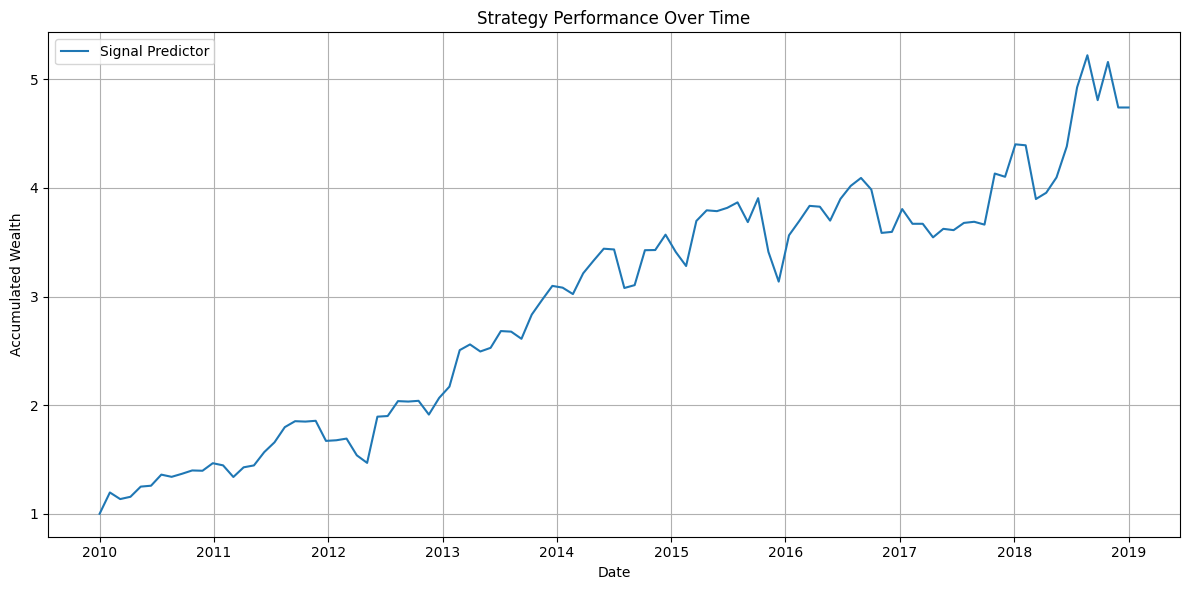

In [17]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end
)

In [8]:
realized_returns_attention_no_embed = realized_returns
pd.Series(realized_returns_attention_no_embed).to_csv('realized_returns_attention_embed.csv')